# 3. 下游分析1

In [1]:
import sys
sys.path = ["../../.."] + sys.path # 切换到项目目录下

import scvelo as scv
import velovgi

Global seed set to 0
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/usr/local/conda/envs/velovi-env/lib/python3.8/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


## 1. 读取数据

In [2]:
# 红系成熟部分
adata_filename = "./data/erythroid_lineage.h5ad"

adata = scv.read(adata_filename)
batch_key = "stage"
cluster_key = "celltype"
adata

AnnData object with n_obs × n_vars = 500 × 53801
    obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm'
    uns: 'celltype_colors'
    obsm: 'X_pca', 'X_umap'
    layers: 'spliced', 'unspliced'

In [3]:
adata_bak = adata.copy()

## 2. 其他批次结果整合的结果对比

In [4]:
adata_review = scv.read("./data/erythroid_lineage_review.h5ad")
adata_latentvelo = scv.read("./data/erythroid_lineage_latentvelo.h5ad")

scv.tl.velocity(adata_review)
scv.tl.velocity_graph(adata_review)

scv.tl.velocity(adata_latentvelo)
scv.tl.velocity_graph(adata_latentvelo)

adata_review, adata_latentvelo

computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph (using 1/12 cores)


  0%|          | 0/500 [00:00<?, ?cells/s]

    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


(AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'MURK_gene', 'Δm', 'scaled Δm', 'means', 'dispersions', 'dispersions_norm', 'highly_variable', 'velocity_gamma', 'velocity_qreg_ratio', 'velocity_r2', 'velocity_genes'
     uns: 'celltype_colors', 'neighbors', 'velocity_params', 'velocity_graph', 'velocity_graph_neg'
     obsm: 'X_pca', 'X_umap'
     layers: 'Ms', 'Mu', 'spliced', 'unspliced', 'velocity', 'variance_velocity'
     obsp: 'connectivities', 'distances',
 AnnData object with n_obs × n_vars = 500 × 2000
     obs: 'sample', 'stage', 'sequencing.batch', 'theiler', 'celltype', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition'
     var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'M

load ./data/adata//adata.h5ad
load ./data/adata//sample_recover.pkl


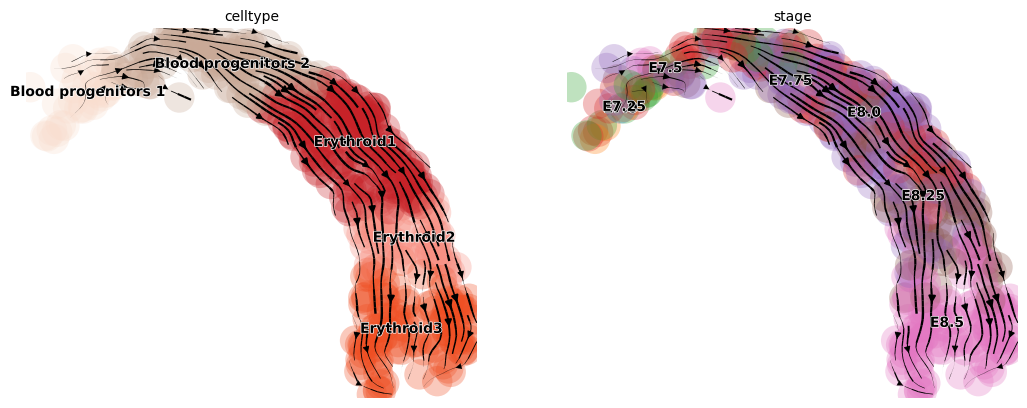

In [5]:
adata = velovgi.tl.read_adata("./data/adata/") # 后续的绘图都是在这个处理后的adata上做的
scv.pl.velocity_embedding_stream(adata, color=[cluster_key, batch_key]) # 添加批次的颜色
adata_review.uns["%s_colors"%batch_key] = adata.uns["%s_colors"%batch_key]
adata_latentvelo.uns["%s_colors"%batch_key] = adata.uns["%s_colors"%batch_key]

1. 可视化对比，只能恢复一些局部的分化方向，而无法恢复全局

computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


<AxesSubplot: title={'center': 'velovgi'}>

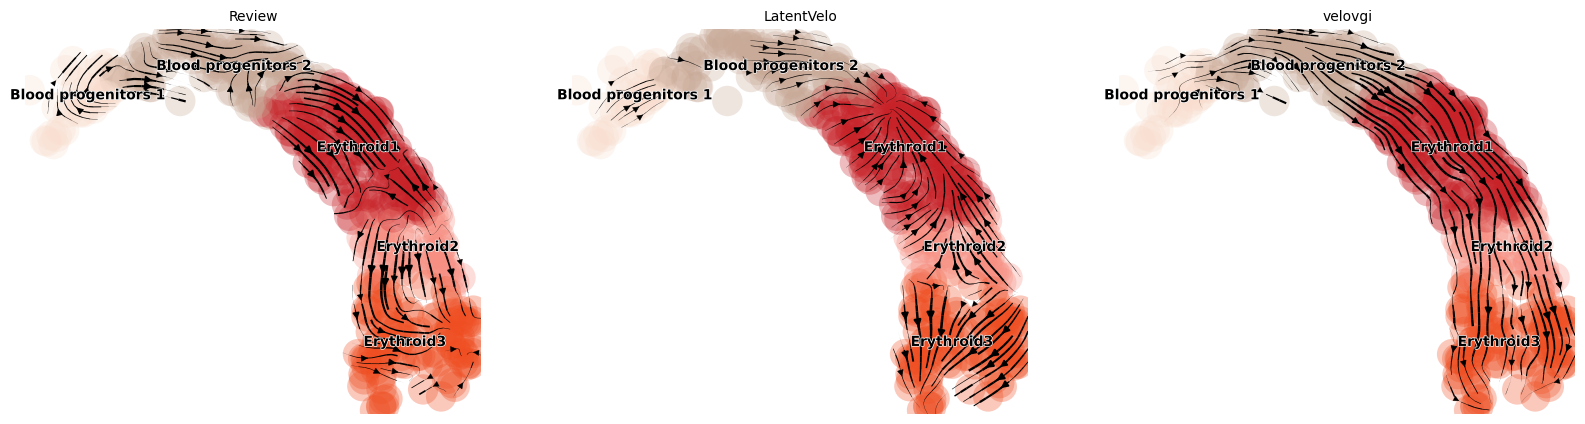

In [6]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(20,5))
scv.pl.velocity_embedding_stream(adata_review, color=cluster_key, title="Review", ax=ax[0], show=False)
scv.pl.velocity_embedding_stream(adata_latentvelo, color=cluster_key, title="LatentVelo", ax=ax[1], show=False)
scv.pl.velocity_embedding_stream(adata, color=cluster_key, title="velovgi", ax=ax[2], show=False)

2. 指标对比

区分模型和数据


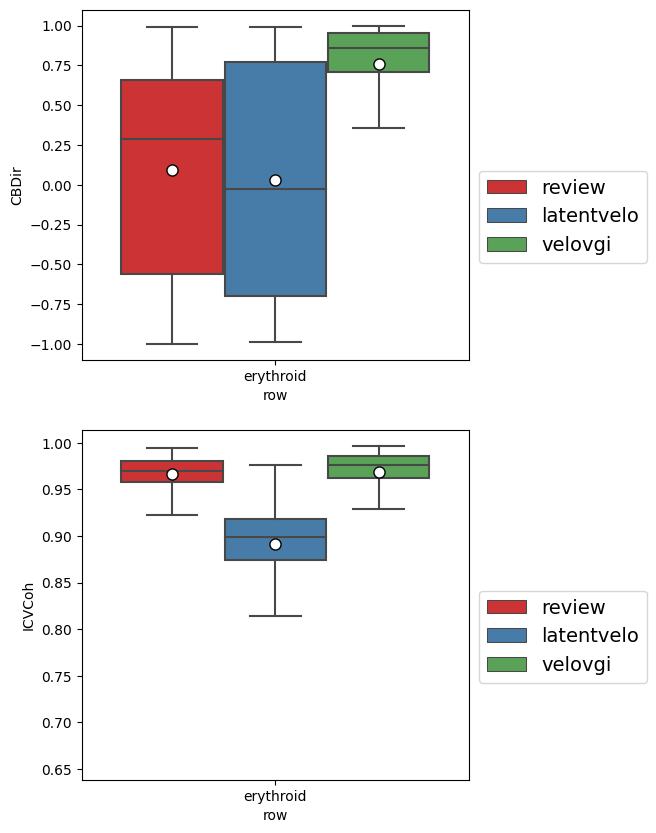

In [7]:
cluster_edges = [
    ("Blood progenitors 1", "Blood progenitors 2"), 
    ("Blood progenitors 2", "Erythroid1"), 
    ("Erythroid1", "Erythroid2"), 
    ("Erythroid2", "Erythroid3")
    ] # 已知的细胞类型间的分化信息

model_names = ["review_erythroid", "latentvelo_erythroid", "velovgi_erythroid"] # 指标结果名称遵循特定的规则：模型_数据
adata_list = [adata_review, adata_latentvelo, adata]

df = velovgi.tl.get_metric_total_df(model_names, adata_list, cluster_edges, cluster_key) # 指标计算
velovgi.pl.plot_metric_total_df(df) # 指标绘制

## 3. 图结构展示

1. 弦图

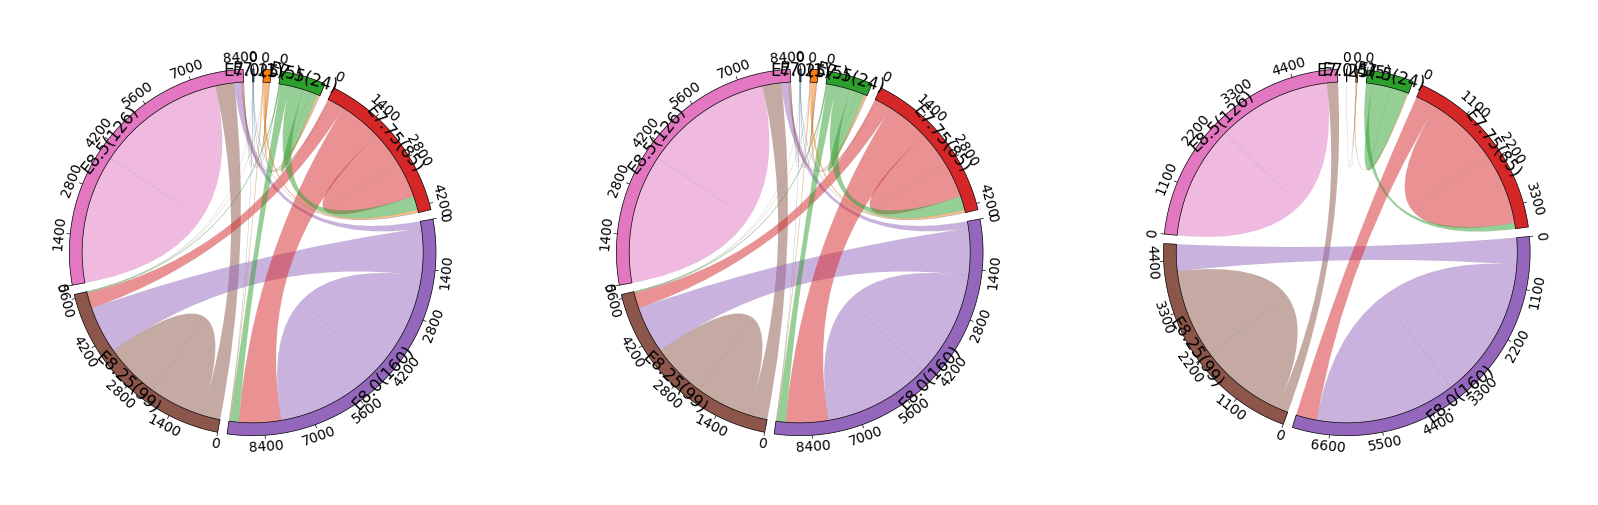

In [8]:
circos_fig, circos_ax = plt.subplots(1, 3, figsize=(20,5), subplot_kw=dict(projection="polar")) # 弦图


velovgi.pl.draw_batch_circos_ax(adata_review, batch_key=batch_key, ax=circos_ax[0])
velovgi.pl.draw_batch_circos_ax(adata_latentvelo, batch_key=batch_key, ax=circos_ax[1])
velovgi.pl.draw_batch_circos_ax(adata, batch_key=batch_key, ax=circos_ax[2])

2. 邻居个数图

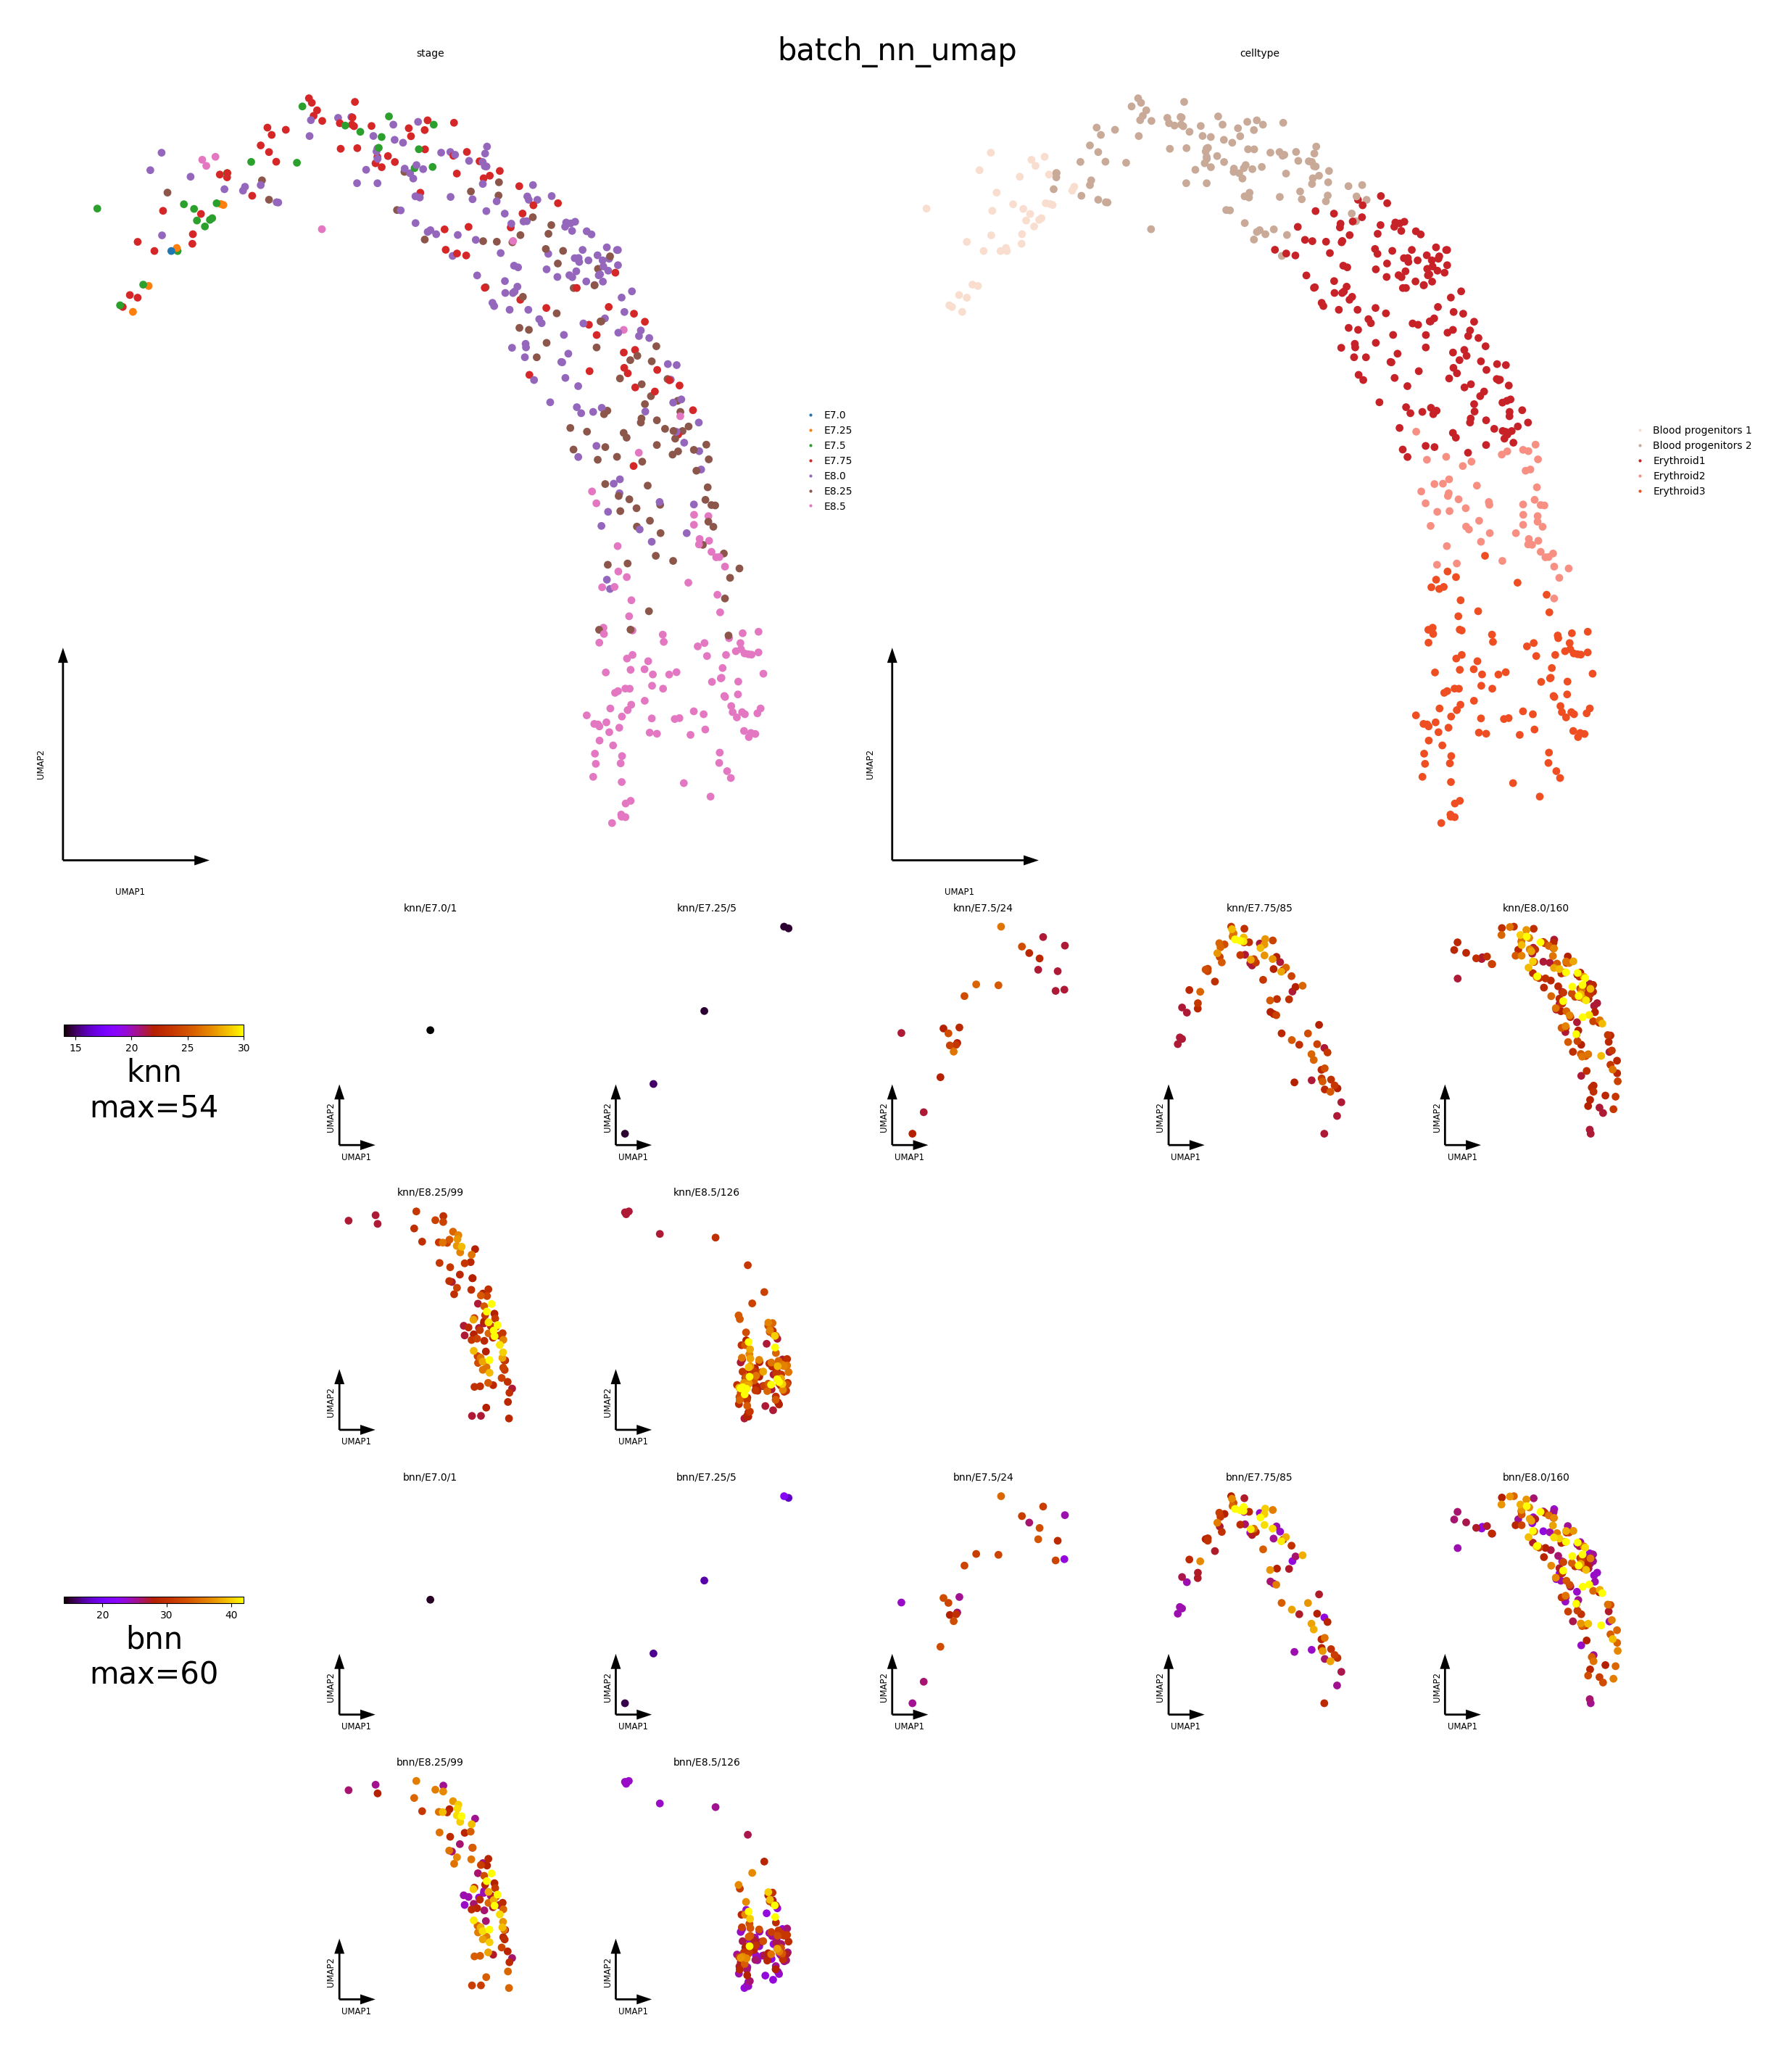

In [9]:
velovgi.pl.draw_batch_nn_umap(adata, batch_key=batch_key, cluster_key=cluster_key, save="tmp2.jpg")

## 4. 基因速率的查看

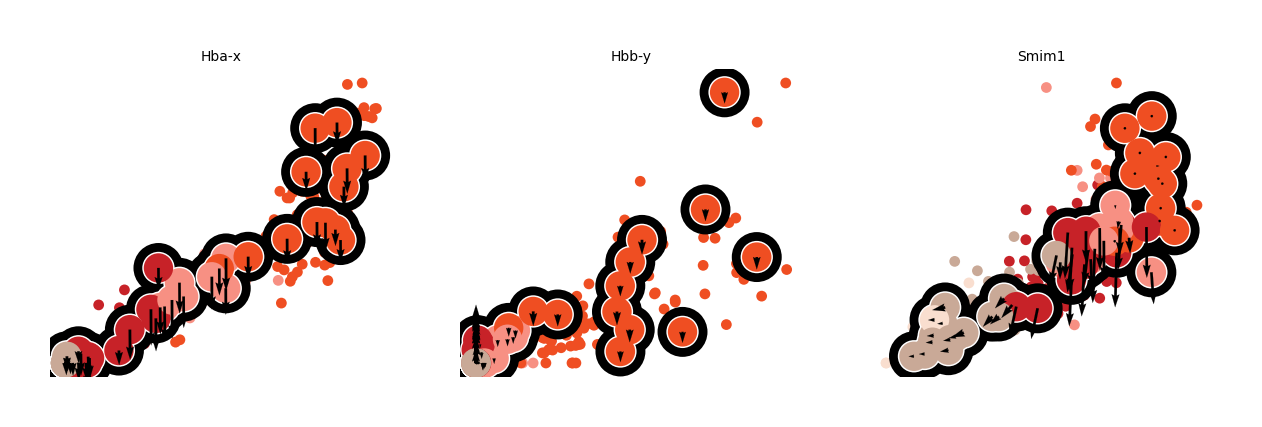

In [10]:
gene_list = ["Hba-x", "Hbb-y", "Smim1"]

velovgi.pl.draw_velocity_gene_list(adata, gene_list, cluster_key=cluster_key, cols=5)

## 5. 速率的伪时间查看

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 4 regions of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)


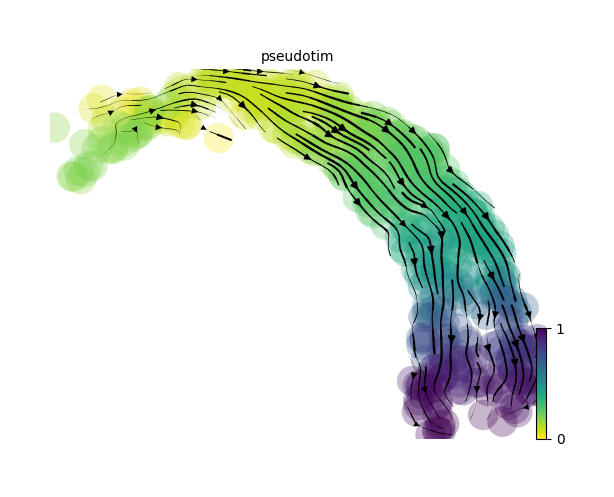

In [11]:
scv.tl.velocity_pseudotime(adata) # 速率的伪时间计算
scv.pl.velocity_embedding_stream(adata, color="velocity_pseudotime", title="pseudotim")

## 6. 隐层表示提取

In [12]:
# 结果提取
velovgi_model = velovgi.tl.VELOVGI.load("model/500_epoch(max_epochs=500)", adata=adata, use_gpu=True) # 需要根据gpu进行调换

INFO     File model/500_epoch(max_epochs=500)/model.pt already downloaded                                          


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


computing velocity embedding
    finished (0:00:00) --> added
    'velocity_latent_umap', embedded velocity vectors (adata.obsm)


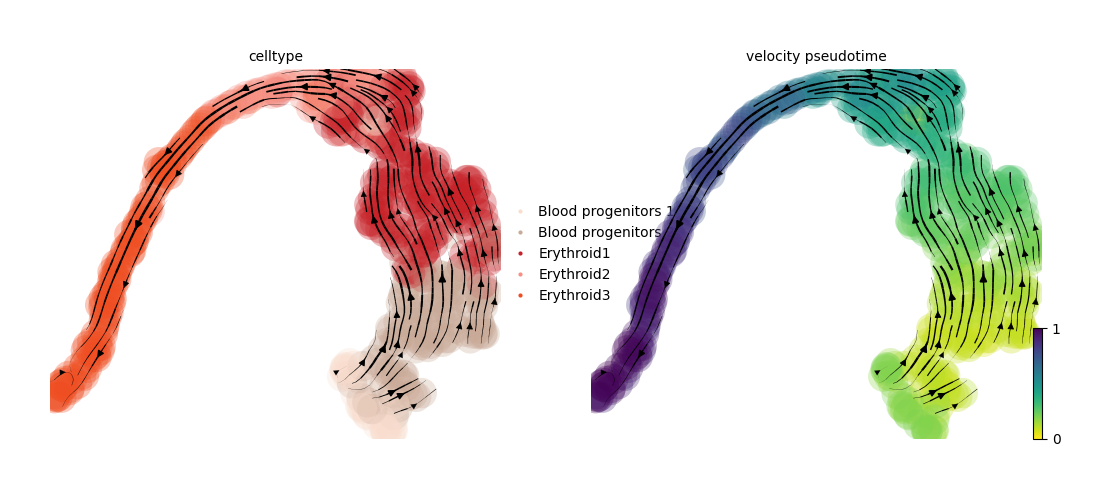

In [13]:
latent_umap_key = "X_latent_umap"
velovgi.tl.get_latent_umap(adata, velovgi_model, latent_umap_key=latent_umap_key)

scv.pl.velocity_embedding_stream(adata, color=[cluster_key, "velocity_pseudotime"], basis=latent_umap_key, legend_loc="right")

## 寻找基因利用权重解释

1. 经过编码器的隐变量

Text(70.72222222222221, 0.5, 'Latent Dimensions')

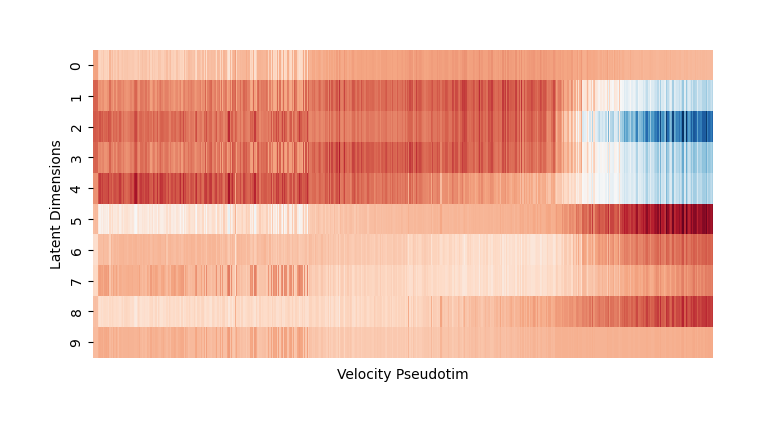

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

figsize = (8, 4)
plt.figure(figsize=figsize)

# 隐变量排序
sorted_index = adata.obs["velocity_pseudotime"].sort_values().index
sorted_adata = adata[sorted_index]
latent_reprentation = sorted_adata.obsm["X_latent"]

# 显示聚类相关的颜色
color_dict = dict(zip(adata.obs[cluster_key].cat.categories, adata.uns["%s_colors"%cluster_key]))
color_list = adata.obs[cluster_key].apply(lambda x: color_dict[x]).to_numpy()

# 绘制隐变量热图
# sns.clustermap(latent_reprentation, row_cluster=False, col_cluster=False, row_colors=color_list, cbar_pos=(1, 0.05, 0.05, 0.3), cmap="RdBu_r")
sns.heatmap(latent_reprentation.T, cmap="RdBu_r", cbar=False) # 不要颜色条
plt.xticks([])
plt.xlabel("Velocity Pseudotim")
plt.ylabel("Latent Dimensions")

2. 编码器的特征提取整体与部分权重可视化

<AxesSubplot: >

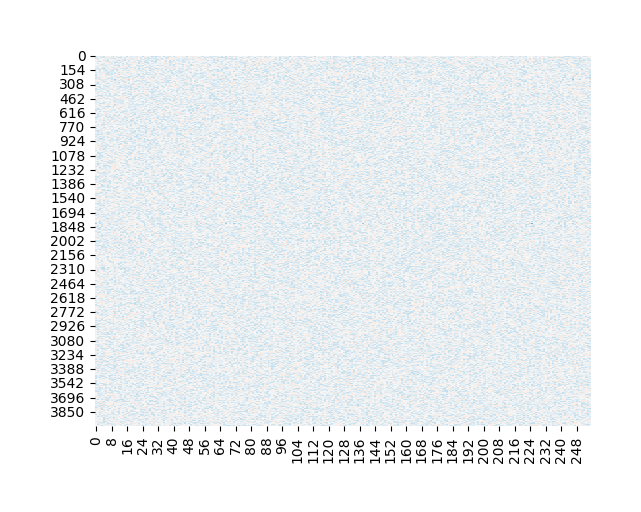

In [15]:
import numpy as np

gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
sns.heatmap(gcn_weight.T, cmap="RdBu_r", cbar=False)

In [31]:
import pandas as pd

[1645, 304, 1644, 305, 306]


,0,1,2,3,4,5,6,7,8,9,...,246,247,248,249,250,251,252,253,254,255
Hbb-y,0.101897,-0.096373,0.097254,-0.045627,0.057541,-0.142893,0.084281,0.081968,0.098986,-0.107360,...,-0.152468,-0.116654,0.084767,0.095782,-0.118806,-0.089529,-0.062009,0.071220,-0.130678,-0.090657
Hba-x,0.046297,-0.053908,0.027057,-0.033813,-0.010304,0.007842,0.033630,0.005922,0.054013,-0.026840,...,-0.109504,-0.010831,0.092681,-0.010609,-0.005124,-0.024529,0.056072,0.037552,-0.020586,-0.055884
Hbb-bh1,-0.032193,0.018360,-0.016943,-0.011789,0.041815,0.010825,-0.020910,0.031330,0.021652,0.020482,...,-0.141418,0.015586,0.125397,-0.010695,0.007257,0.008625,0.078214,0.017514,0.018316,0.024514
Hba-a1,0.038194,0.015487,0.030142,0.008759,0.030485,0.005982,0.028159,0.034114,0.010177,-0.032712,...,-0.075239,-0.017292,0.060378,0.045608,0.013857,0.011639,-0.004131,-0.004993,-0.012770,0.019333
Hba-a2,-0.010353,-0.037573,0.014599,-0.035170,0.021904,0.016933,0.048139,0.015625,0.039999,0.001426,...,-0.103895,-0.020232,0.021783,0.051529,-0.009490,-0.009738,0.032181,0.037766,0.006276,-0.007326


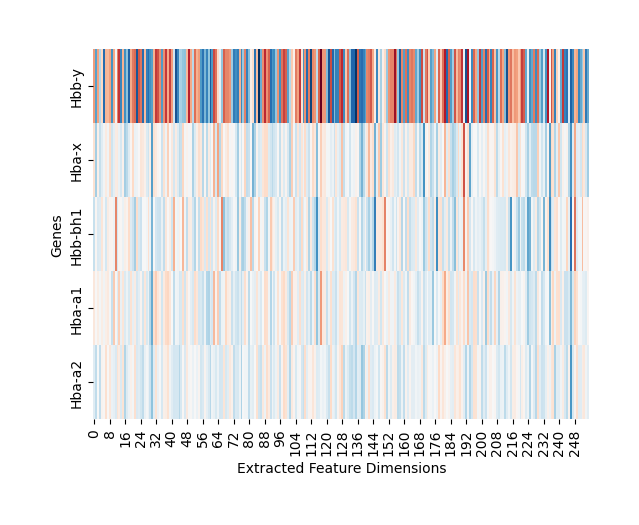

In [32]:
n_top = 5
feature_gcn_weight = velovgi_model.module.z_encoder.encoder.gnn_layers[0][0].lin.weight.detach().cpu().numpy()
# index_list = list(np.argsort(feature_gcn_weight.mean(axis=0))[::-1][:n_top])  # 权重最大的前几个
index_list = list(np.argsort(np.abs(feature_gcn_weight).mean(axis=0))[::-1][:n_top])  # 权重绝对值最大的前几个
print(index_list)

gene_index_list = []
for index in index_list:
    if index > 2000:
        index = index-2000
    gene_index_list.append(index)

# 添加基因名
gene_name_list = list(adata.var.iloc[gene_index_list].index)
feature_df = pd.DataFrame(gcn_weight[:, gene_index_list].T)
feature_df.index = gene_name_list

sns.heatmap(feature_df, cmap="RdBu_r", cbar=False)  # 不要颜色条
plt.xlabel("Extracted Feature Dimensions")
plt.ylabel("Genes")

feature_df # 这些基因就可以作为候选的标记基因了

2. 提取与Hbb-y相关性很强的特征

In [38]:
# 综合前几个基因的特征，效果不好
# n_top = 110
# feature_index_list = []
# for gene in feature_df.index:
#     print(gene)
#     tmp_feature_index_list = list(np.argsort(feature_df.loc[gene])[::-1][:n_top])
#     if feature_index_list == []:
#         feature_index_list = tmp_feature_index_list
#     else:
#         feature_index_list = list(set.intersection(set(tmp_feature_index_list), set(feature_index_list)))
# feature_index_list

In [39]:
top_n = 2
positive_feature_index_list = list(np.argsort(feature_df.loc["Hbb-y"])[::-1][:top_n]) # 与Hbb-y相关的特征
negtive_feature_index_list = list(np.argsort(feature_df.loc["Hbb-y"])[:top_n]) # Hbb-y负相关的特征

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

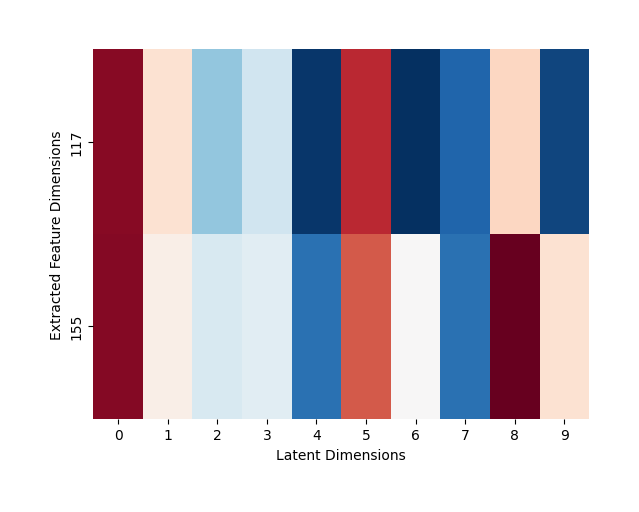

In [40]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, positive_feature_index_list].T)
df.index = positive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

Text(50.722222222222214, 0.5, 'Extracted Feature Dimensions')

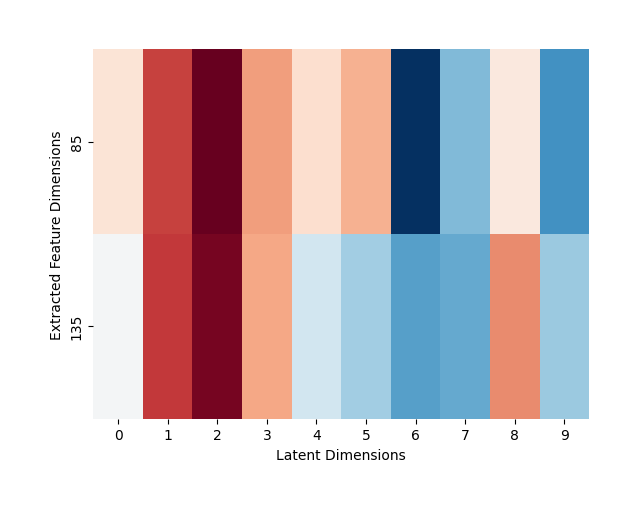

In [41]:
mean_weight = velovgi_model.module.z_encoder.mean_encoder.lin.weight.detach().cpu().numpy()
df = pd.DataFrame(mean_weight[:, negtive_feature_index_list].T)
df.index = negtive_feature_index_list
sns.heatmap(df, cmap="RdBu_r", cbar=False)
plt.xlabel("Latent Dimensions")
plt.ylabel("Extracted Feature Dimensions")

In [ ]:
# var_weight = velovgi_model.module.z_encoder.var_encoder.lin.weight.detach().cpu().numpy()
# df = pd.DataFrame(var_weight[:, positive_feature_index_list].T)
# df.index = feature_index_list
# sns.heatmap(df, cmap="RdBu_r", cbar=False)
# plt.xlabel("Latent Dimensions")
# plt.ylabel("Feature Extraction Dimensions")